In [136]:
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import datetime

In [137]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [138]:
startTime = datetime.datetime.now()

In [139]:
torch.manual_seed(190401094)

In [140]:
batch_size = 16

In [141]:
# Veri setlerini yükleme
train_df = pd.read_csv('/content/drive/MyDrive/yapaysiniraglari/cure_the_princess_train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/yapaysiniraglari/cure_the_princess_test.csv')
val_df = pd.read_csv('/content/drive/MyDrive/yapaysiniraglari/cure_the_princess_validation.csv')

# Model eğitme
from torch.utils.data import DataLoader, TensorDataset
train_inputs = train_df.drop('Cured', axis=1).values
train_labels = train_df['Cured'].values
train_dataset = TensorDataset(torch.tensor(train_inputs, dtype=torch.float), torch.tensor(train_labels, dtype=torch.long))

val_inputs = val_df.drop('Cured', axis=1).values
val_labels = val_df['Cured'].values
val_dataset = TensorDataset(torch.tensor(val_inputs, dtype=torch.float), torch.tensor(val_labels, dtype=torch.long))

test_inputs = test_df.drop('Cured', axis=1).values
test_labels = test_df['Cured'].values
test_dataset = TensorDataset(torch.tensor(test_inputs, dtype=torch.float), torch.tensor(test_labels, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [142]:
# Model tanımlama
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        #Ilk hidden layer’da 100, ikinci hidden layer’da 50 nöron olsun
        self.fc1 = nn.Linear(len(train_df.columns) - 1, 100) 
        self.fc2 = nn.Linear(100, 50) 
        self.fc3 = nn.Linear(50, 2)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        output = nn.functional.relu(self.fc1(x))
        output = nn.functional.relu(self.fc2(output))
        output = self.fc3(output)
        return self.sigmoid(output)
        
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MyModel().to(device)

In [143]:
#Loss function ve optimizer tanımlama
criterion=nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [144]:
def evulate(valid_loader):
  model.eval()
  val_loss = 0.0
  val_correct = 0
  val_total = 0
  with torch.no_grad():
      for inputs, labels in valid_loader:
          inputs = inputs.to(device)
          labels = labels.to(device)
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          val_loss += loss.item()
          _, predicted = outputs.max(1)
          val_total += labels.size(0)
          val_correct += predicted.eq(labels).sum().item()
  val_loss /= len(valid_loader)
  val_accuracy = 100. * val_correct / val_total
  val_loss_list.append(val_loss)
  val_score=val_loss
  return val_accuracy, val_score, val_loss

In [145]:
def modeltrain():
  train_loss, correct, total = 0.0 , 0 , 0
  for inputs, labels in train_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  train_loss /= len(train_loader)
  train_accuracy = 100. * correct / total
  loss_list.append(train_loss)
  return train_loss, train_accuracy

In [146]:
# Train function tanımlama
def train(model, criterion, optimizer, train_loader, valid_loader, num_epochs, best_val_loss):
    for epoch in range(num_epochs):
       # Model eğitimi
        model.train()
        train_loss, train_accuracy = modeltrain()
       # Değerlendirme
        val_accuracy, val_score, val_loss = evulate(valid_loader)
        #Early Stopping
        if best_val_loss is None:
          patience_counter=0
          best_val_loss=val_score       
          torch.save(model.state_dict(),"checkpoint.pt")
        else:
            if best_val_loss<val_score:     
              patience_counter+=1
              print("Earlystopping Patience Counter",patience_counter)
              if patience_counter==patience:
                print("EARLYSTOPPED!")
                return epoch+2
            else:
              best_val_loss=val_score
              torch.save(model.state_dict(),"checkpoint.pt")       
              patience_counter=0       
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}")

In [147]:
num_epochs = 50
loss_list = []
val_loss_list = []
patience=5
best_val_loss = None
break_value=train(model, criterion, optimizer, train_loader, val_loader, num_epochs, best_val_loss)

Epoch [1/50], Train Loss: 0.6812, Train Acc: 53.51, Val Loss: 0.6292, Val Acc: 68.15
Epoch [2/50], Train Loss: 0.6041, Train Acc: 73.72, Val Loss: 0.5491, Val Acc: 82.17
Epoch [3/50], Train Loss: 0.5465, Train Acc: 80.35, Val Loss: 0.4990, Val Acc: 87.58
Epoch [4/50], Train Loss: 0.5128, Train Acc: 83.31, Val Loss: 0.4624, Val Acc: 90.76
Epoch [5/50], Train Loss: 0.4849, Train Acc: 85.14, Val Loss: 0.4428, Val Acc: 90.45
Epoch [6/50], Train Loss: 0.4708, Train Acc: 86.18, Val Loss: 0.4297, Val Acc: 91.72
Earlystopping Patience Counter 1
Epoch [7/50], Train Loss: 0.4586, Train Acc: 87.06, Val Loss: 0.4451, Val Acc: 86.94
Epoch [8/50], Train Loss: 0.4527, Train Acc: 86.82, Val Loss: 0.4120, Val Acc: 92.04
Epoch [9/50], Train Loss: 0.4435, Train Acc: 88.18, Val Loss: 0.4112, Val Acc: 91.08
Epoch [10/50], Train Loss: 0.4378, Train Acc: 88.82, Val Loss: 0.4053, Val Acc: 93.31
Earlystopping Patience Counter 1
Epoch [11/50], Train Loss: 0.4356, Train Acc: 88.74, Val Loss: 0.4141, Val Acc: 91.

In [148]:
from sklearn.metrics import  accuracy_score, precision_score, f1_score,recall_score

# Modeli değerlendirme modunda ayarla
model.eval()

# Test seti üzerinde döngüye gir ve tahminler yap
with torch.no_grad():
    true_labels = []
    predicted_labels = []
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        true_labels += labels.cpu().numpy().tolist()
        predicted_labels += predicted.cpu().numpy().tolist()

# Performans metriklerini hesapla
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=1)
recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=1)
f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=1)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Test Accuracy: 0.9326
Precision: 0.9357
Recall: 0.9326
F1 Score: 0.9325


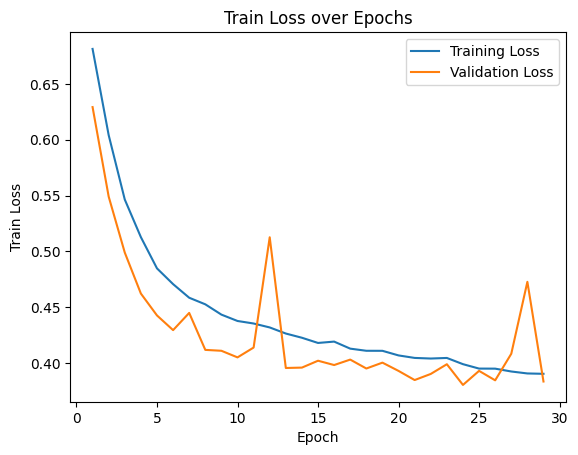

In [149]:
# Train Loss over Epochs figürü çiz
plt.figure()
break_value = num_epochs+1 if break_value is None else break_value
plt.plot(range(1, break_value), loss_list, label= "Training Loss")
plt.plot(range(1, break_value), val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss over Epochs')
plt.legend()
plt.show()

In [150]:
endTime = datetime.datetime.now()
print("Başlangıç Zamanı: ", endTime, "\nBitiş Zamanı: ", endTime, "\nToplam Çalışma Süresi:", endTime-startTime , "\nÇalışma Ortamı: ", str(device).upper())

Başlangıç Zamanı:  2023-04-14 09:54:06.935118 
Bitiş Zamanı:  2023-04-14 09:54:06.935118 
Toplam Çalışma Süresi: 0:00:03.482467 
Çalışma Ortamı:  CPU
